# Importing Python Packages and Data

In [1]:
# Import everything needed

import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import matplotlib

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import precision_recall_curve

matplotlib.rcParams['font.family'] = ['arial']

In [2]:
total_data = pd.read_csv("cleaned_data.dbcan_cog_HGT.tsv", sep="\t")

In [3]:
print(total_data.shape)
total_data.head()

(3772, 4565)


,Unnamed: 0,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


In [4]:
# Removing soil! Separating PA and NPA!

df = total_data[total_data["Classification"] != "soil"]
print(df.shape)
df.head()

(3261, 4565)


,Unnamed: 0,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


# Data Preprocessing and Feature Selection, all models

In [5]:
# Scaling data with Standard Scaler, code from Muyoung

features = df.columns[5:]
scaler = StandardScaler().fit(df[features])
df_normalized = pd.DataFrame(scaler.transform(df[features]), columns=features)
df = pd.concat([df.iloc[:, :5], df_normalized], axis=1)
df.head()

,Unnamed: 0,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,0,2511231155,Acinetobacter,NPA,NPA,0.066808,-0.378513,-0.423784,-0.389091,1.002863,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.331415
1,1,2519103115,Acinetobacter,NPA,NPA,0.136692,-0.378513,2.474260,-0.348927,1.096538,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.313281
2,2,2519899735,Acinetobacter,NPA,NPA,0.121340,-0.378513,2.441586,-0.357750,1.075959,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.331415
3,3,2526164562,Acinetobacter,NPA,NPA,1.317699,-0.378513,-0.423784,-0.400855,0.975425,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.218343
4,4,2529293005,Acinetobacter,NPA,NPA,0.123815,-0.378513,2.446855,-0.356327,1.079278,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.294080


In [6]:
# Removing features with zero variance, code from Muyoung 

constant_filter = VarianceThreshold(threshold=0) 
constant_filter.fit(df[features])
features = constant_filter.get_feature_names_out(features)

X = df[features]
y = df["Classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Feature Selection

In [22]:
# https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter = 1000)
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X, y)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear', max_iter = 1000)
model.fit(X, y)
coef = model.coef_[0]

/Users/Sarah/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
imp_features = pd.Series(X.columns)[list(coef!=0)]
X_train = X_train[imp_features]
X_test = X_test[imp_features]
X = X[imp_features]

In [24]:
imp_features.shape

(294,)

Index(['AA5', 'CBM25', 'CBM4', 'CBM40', 'CBM48', 'CBM59', 'CBM62', 'CE2',
       'GH101', 'GH115',
       ...
       'COG5563', 'COG5565', 'COG5571', 'COG5572', 'COG5579', 'COG5616',
       'COG5617', 'COG5639', 'COG5640', 'COG5655'],
      dtype='object', length=313)

# Data Visualization

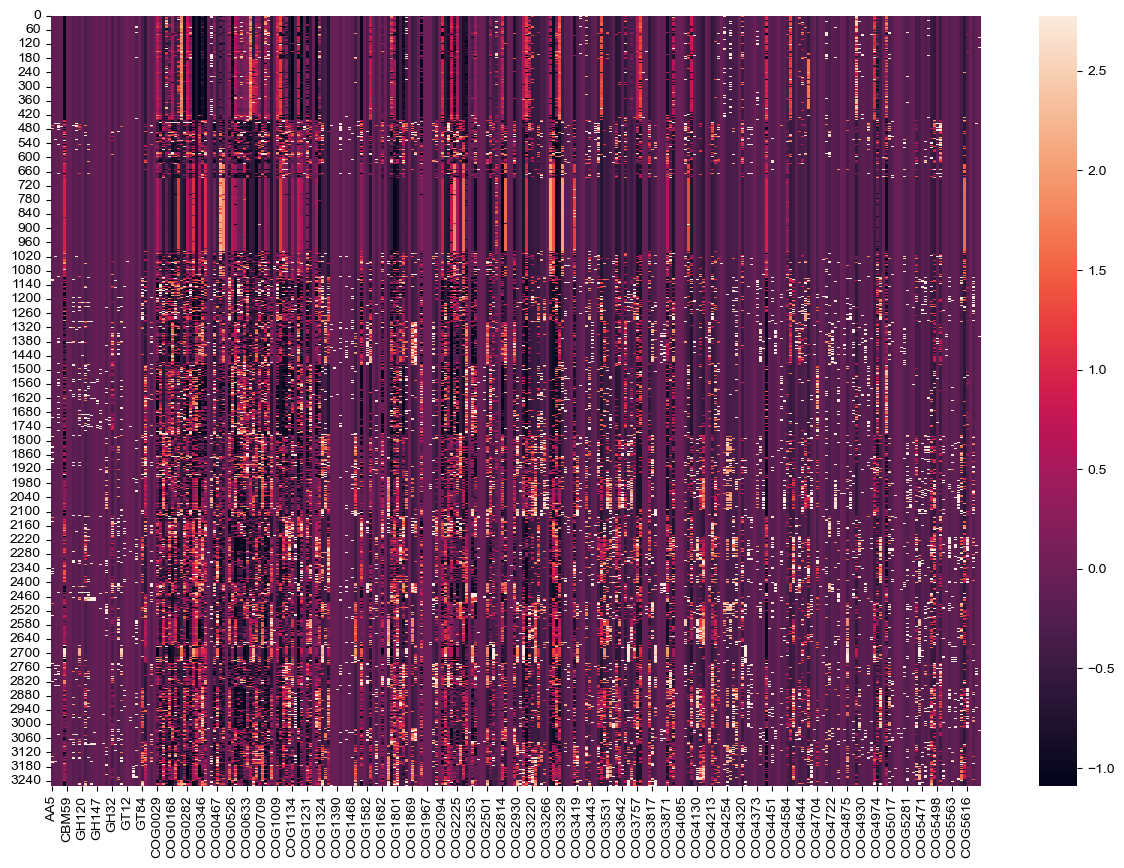

In [170]:
fig, ax = plt.subplots(figsize=(15,10))     
ax = sb.heatmap(X, robust = True) # square = True, 

# Principal Component Analysis

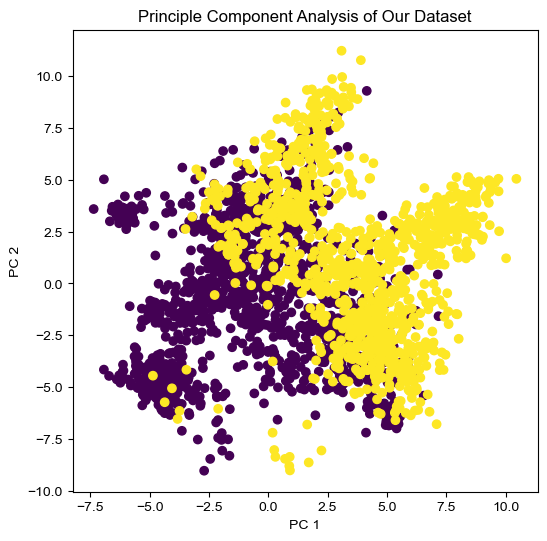

In [171]:
pca = decomposition.PCA(n_components=2)

pca_result = pca.fit_transform(X)

# Making labels for plotting the graph

labels = y.ravel()

for idx, val in enumerate(labels):
    if val == "NPA":
        labels[idx] = 0
    elif val == "PA":
        labels[idx] = 1
    else:
        print("Error!")

x = pca_result[:,0]
y = pca_result[:,1]
plt.figure(figsize=(6, 6))
plt.scatter(x,y, c = labels)

pca_result = pd.DataFrame(pca_result)
    
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Principle Component Analysis of Our Dataset")
plt.savefig("PCA_SDS_Final_Project.svg")
plt.show()

In [172]:
dataset_pca = pd.DataFrame(abs(pca.components_),columns=X.columns, index=['PC_1', 'PC_2'])
dataset_pca.to_csv('PCA_of_Dataset.csv')

# Model Training

## Logistic Regression, Three Penalties

In [173]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [174]:
clf_l1 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'l1', solver = 'saga').fit(X_train, y_train)
clf_l2 = LogisticRegression(random_state=42, max_iter = 500, penalty = 'l2').fit(X_train, y_train)
clf_en = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(X_train, y_train)

In [175]:
y_pred_l1 = clf_l1.predict_proba(X_test)
y_pred_l2 = clf_l2.predict_proba(X_test)
y_pred_en = clf_en.predict_proba(X_test)

In [176]:
clf_l1.score(X_train, y_train)

0.9958791208791209

In [177]:
clf_l2.score(X_train, y_train)

0.9986263736263736

In [178]:
clf_en.score(X_train, y_train)

0.9972527472527473

In [179]:
clf_l1.score(X_test, y_test)

0.8737233054781801

In [180]:
clf_l2.score(X_test, y_test)

0.8802228412256268

In [181]:
clf_en.score(X_test, y_test)

0.8792943361188487

In [182]:
precision_l1, recall_l1, thresholds_l1 = precision_recall_curve(y_test, y_pred_l1[:,0], pos_label = ["NPA"])
precision_l2, recall_l2, thresholds_l2 = precision_recall_curve(y_test, y_pred_l2[:,0], pos_label = ["NPA"])
precision_en, recall_en, thresholds_en = precision_recall_curve(y_test, y_pred_en[:,0], pos_label = ["NPA"])

[]

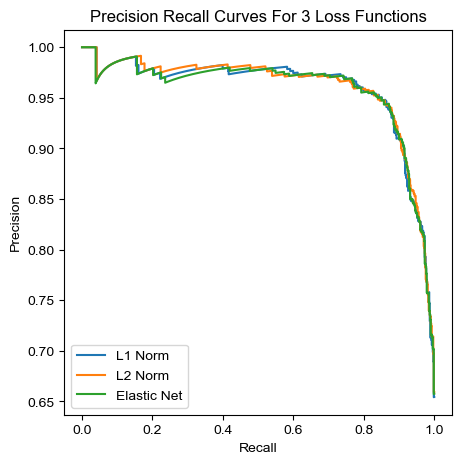

In [183]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_l1, precision_l1)
ax.plot(recall_l2, precision_l2)
ax.plot(recall_en, precision_en)
ax.legend(['L1 Norm', 'L2 Norm', 'Elastic Net'])
ax.set_title('Precision Recall Curves For 3 Loss Functions')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

## Support Vector Machine Classifier

In [198]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svc = SVC(gamma = 'auto', probability = True).fit(X_train, y_train)

In [199]:
clf_svc.score(X_train, y_train)

0.9844322344322345

In [200]:
clf_svc.score(X_test, y_test)

0.8960074280408542

In [201]:
y_pred_1 = clf_svc.predict_proba(X_test)

In [202]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

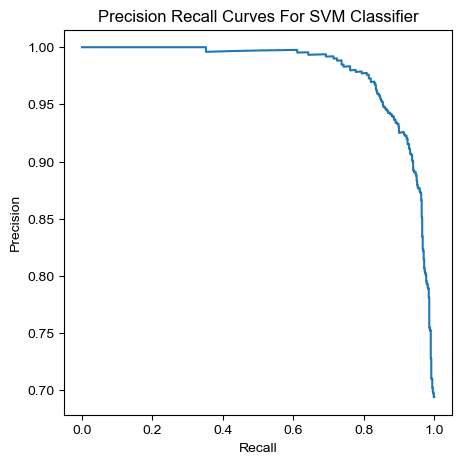

In [203]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For SVM Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

## Gaussian Naive Bayes Classifier

In [190]:
# https://scikit-learn.org/stable/modules/naive_bayes.html BAD AT PREDICTIONS

gnb = GaussianNB().fit(X_train,y_train)

In [191]:
y_pred = gnb.predict_proba(X_test)

In [192]:
gnb.score(X_train,y_train)

0.6831501831501832

In [193]:
gnb.score(X_test,y_test)

0.6527390900649953

In [194]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

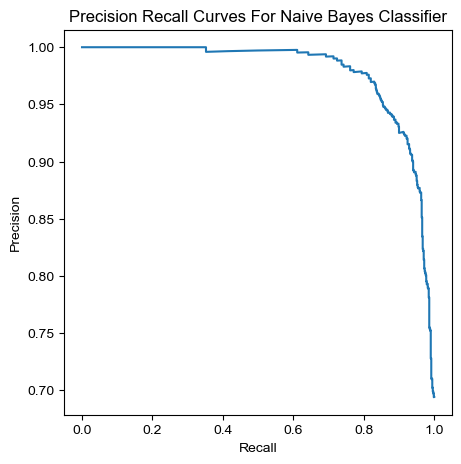

In [195]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For Naive Bayes Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

# Testing on Soil

In [197]:
df_soil = total_data[total_data["Classification"] == "soil"]
X_soil = df_soil[imp_features]

In [215]:
y_pred_l1_soil = clf_l1.predict(X_soil)
y_pred_l2_soil = clf_l2.predict(X_soil)
y_pred_en_soil = clf_en.predict(X_soil)
y_pred_svc_soil = clf_svc.predict(X_soil)
y_pred_gnb_soil = gnb.predict(X_soil)

In [209]:
X_soil.shape

(511, 310)

In [208]:
sum(y_pred_l1_soil == y_pred_l2_soil)

511

In [210]:
sum(y_pred_l1_soil == y_pred_en_soil)

511

In [211]:
sum(y_pred_l1_soil == y_pred_svc_soil)

511

In [216]:
sum(y_pred_l1_soil == y_pred_gnb_soil)

511

In [217]:
# All predictions are the same! This might be because my features are so small (only around 300)